In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [2]:
# GPU対応

from keras.backend import tensorflow_backend
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

Using TensorFlow backend.


In [3]:
# 手書き数字画像取得
np.random.seed(0)
(X_train, labels_train), (X_test, labels_test) = mnist.load_data()

X_train, X_validation, labels_train, labels_validation = train_test_split(X_train, labels_train, test_size=0.2)

print('X_train.shape', X_train.shape)
print('X_validation.shape', X_validation.shape)
print('X_test.shape', X_test.shape)

X_train.shape (48000, 28, 28)
X_validation.shape (12000, 28, 28)
X_test.shape (10000, 28, 28)


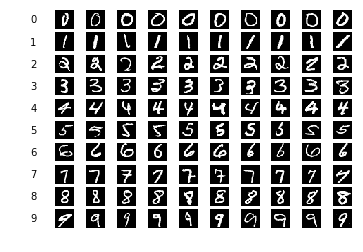

In [4]:
# 画像確認

label_images = {label: [] for label in set(labels_train.tolist())}
for x, label in zip(X_train, labels_train):
    if all(len(images) >= 10 for images in label_images.values()):
        break
    if len(label_images[label]) >= 10:
        continue
    label_images[label].append(x)
    
for j, (label, images) in enumerate(label_images.items()):
    plt.subplot(10, 11, j * 11 + 1)
    plt.text(0.5, 0.5, label, ha='center', va='center')
    plt.axis('off')
    for i, image in enumerate(images):
        if i >= 10:
            continue
        plt.subplot(10, 11, j * 11 +  i + 2)
        plt.imshow(image, cmap='Greys_r')
        plt.axis('off')
plt.show()
    
del label_images

In [5]:
# 前処理

## 正規化
X_train = X_train.reshape((-1, 784)).astype('float32')
X_validation = X_validation.reshape((-1, 784)).astype('float32')
X_test = X_test.reshape((-1, 784)).astype('float32')

X_train /= 255
X_validation /= 255
X_test /= 255

## 加工 for CNN
X_train = X_train.reshape((-1, 28, 28, 1)).astype('float32')
X_validation = X_validation.reshape((-1, 28, 28, 1)).astype('float32')
X_test = X_test.reshape((-1, 28, 28, 1)).astype('float32')

# one-hotラベル
y_train = tf.keras.utils.to_categorical(labels_train)
y_validation = tf.keras.utils.to_categorical(labels_validation)
y_test = tf.keras.utils.to_categorical(labels_test)

In [6]:
# Model

model = Sequential()

model.add(
    Conv2D(
        64, 
        kernel_size=(3, 3), 
        activation='relu', 
        input_shape=(X_train[0].shape),
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1),
        bias_initializer=keras.initializers.constant(0.1)
    )
)
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(rate=0.2))

model.add(
    Conv2D(
        128, 
        kernel_size=(3, 3), 
        activation='relu',
    )
)
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(rate=0.2))

model.add(Flatten())

model.add(
    Dense(
        10, 
        activation='softmax'
    )
)

model.compile(
    optimizer=tf.train.AdamOptimizer(0.01),
    loss='categorical_crossentropy', 
    metrics=['mae', 'accuracy']
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
# Fitting

log = model.fit(
    X_train, 
    y_train, 
    epochs=300, 
    batch_size=1500, 
    verbose=False,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            min_delta=0, 
            patience=20, 
            verbose=1
        )
    ],
    validation_data=(X_validation, y_validation)
)

Instructions for updating:
Use tf.cast instead.
Epoch 00114: early stopping


In [8]:
# Results

print('Accuracy', log.history['acc'][-1])
print('Loss', log.history['loss'][-1])

Accuracy 0.98477083
Loss 0.045640318479854614


In [9]:
# Prediction

pred_test = model.predict_classes(X_test)
validation = (pred_test == labels_test)
size       = validation.size
size
correct    = np.count_nonzero(validation)
print(f" {correct}/{size} actual correct ({correct*100/size:.3f}%)")

 9880/10000 actual correct (98.800%)


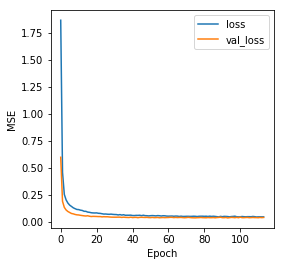

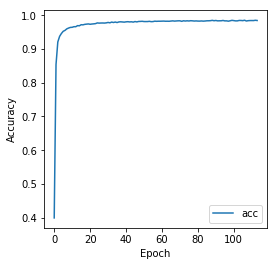

In [10]:
# Graphs

fig = plt.figure(figsize=(4,4))
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend(frameon=True)
plt.show()

fig = plt.figure(figsize=(4,4))
plt.plot(log.history['acc'], label='acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(frameon=True)
plt.show()